# Basic statistics of the comment column
We will look now at the comment column and show some basic statistics with it.
We will use the **comment_length**, **word_count**, **is_reply** and **emoji_count**. These columns are present in the clean dataset, so **there is no necessity to have the enriched columns for the current notebook.**

We start with the standard imports, plus some useful imports for plotting with python, lke searborn and matplotlib.

The current analysis was done for the YouTube channel: **Kurzgesagt In a Nutshell**

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths

channel_paths = Paths(channel_handle=config.channel_handle)

### Read the columns from all existing clean files

In [6]:
df = pl.concat([pl.read_parquet(file, columns=['comment_length', 'word_count', 'is_reply', 'emoji_count']) for file in channel_paths.list_processed_files()])
print(f"There is a total of {df.height:_} comments.")

There is a total of 4_959_039 comments.


Some basic profiling of comment_lenth, word_count and emoji_count. We include:
- Mean
- Median
- Min
- Max

In [7]:
df.select([
    pl.col("comment_length").mean().alias("mean_comment_length"),
    pl.col("comment_length").median().alias("median_comment_length"),
    pl.col("comment_length").min().alias("min_comment_length"),
    pl.col("comment_length").max().alias("max_comment_length"),
    
    pl.col("word_count").mean().alias("mean_word_count"),
    pl.col("word_count").median().alias("median_word_count"),
    pl.col("word_count").min().alias("min_word_count"),
    pl.col("word_count").max().alias("max_word_count"),
    
    pl.col("emoji_count").mean().alias("mean_emoji_count"),
    pl.col("emoji_count").median().alias("median_emoji_count"),
    pl.col("emoji_count").min().alias("min_emoji_count"),
    pl.col("emoji_count").max().alias("max_emoji_count"),
    pl.col("emoji_count").filter(pl.col("emoji_count") > 0).len().alias("comments_w_emoji"),
    (pl.col("emoji_count").filter(pl.col("emoji_count") > 0).len() / pl.len() * 100).alias("comments_w_emoji_%"),
    
    pl.len().alias("total_comments")
])

mean_comment_length,median_comment_length,min_comment_length,max_comment_length,mean_word_count,median_word_count,min_word_count,max_word_count,mean_emoji_count,median_emoji_count,min_emoji_count,max_emoji_count,comments_w_emoji,comments_w_emoji_%,total_comments
f64,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,u32,f64,u32
133.050889,62.0,0,231223,23.584257,11.0,0,28102,0.225791,0.0,0,2526,308052,6.211929,4959039


In [8]:
# Basic counts of is_reply column
df.select([
    pl.col("is_reply").value_counts()
])

is_reply
struct[2]
"{true,1876635}"
"{false,3082404}"


## Working with pandas from this point
Turns out that polars for the moment doesn't couple well with the plotting libraries we will use, so we will convert the polars dataframe to pandas dataframe.

In [9]:
df_pd = df.select(['comment_length', 'word_count', 'emoji_count', 'is_reply']).to_pandas()

# Boxplot comment length
A boxplot is useful to display the distribution of a variable.
The boxplot for the comment_length shows the data is skewed to the right, showing a non unimportant number of outliers, that groups the data to the left. Note also, that the outliers have very long comment lengths, going beyond 10,000 characters.

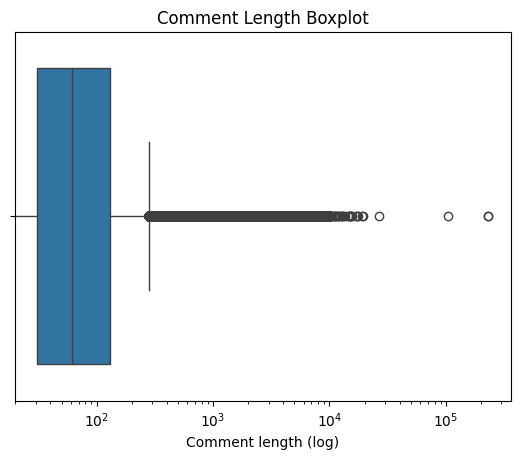

In [ ]:
sns.boxplot(x=df_pd["comment_length"])
plt.title("Comment Length Boxplot")
plt.xlabel("Comment length (log)")
plt.xscale("log")
plt.show()

## Filtering top 5% comments by length
We will filter out the top 5% of the comments by its length, and see how the variable behaves.

In [16]:
# Compute the 95th percentile (i.e., upper threshold)
cutoff = df_pd["comment_length"].quantile(0.95)

# Filter the DataFrame to keep only the bottom 95%
df_filtered_pd = df_pd[df_pd["comment_length"] <= cutoff]

This time we didn't have to show the x axis as a logarithm.

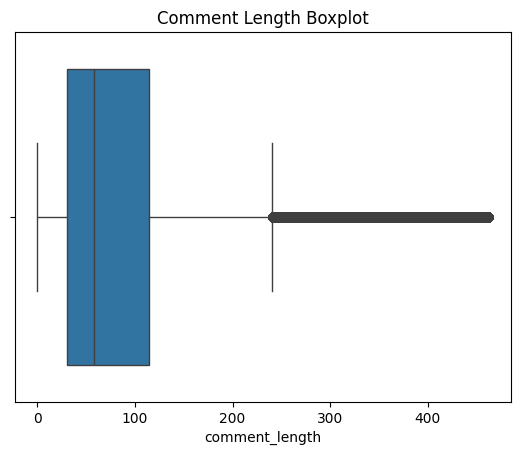

In [ ]:
sns.boxplot(x=df_filtered_pd["comment_length"])
plt.title("Comment Length Boxplot")
plt.xlabel("Comment length")
plt.show()

### Distribution of comment length
Due to the skewed nature of the comments, the mean comment lenth is higher than the median comment length.

The median comment length of 58, means that the comment length that sits right in the middle of the data is a comment of 58 charcters long.

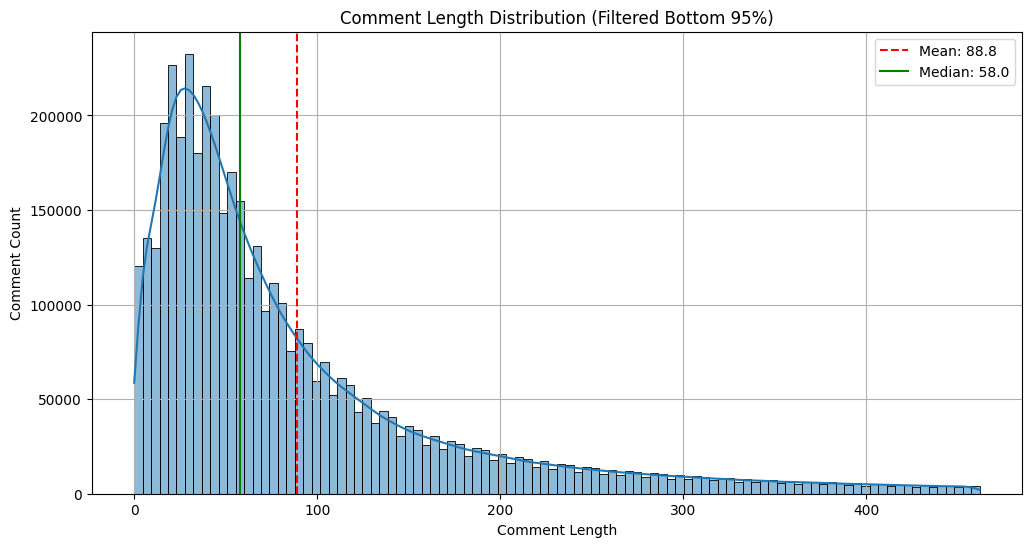

In [24]:
mean_val = df_filtered_pd["comment_length"].mean()
median_val = df_filtered_pd["comment_length"].median()

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered_pd["comment_length"], bins=100, kde=True)
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.1f}')
plt.title("Comment Length Distribution (Filtered Bottom 95%)")
plt.xlabel("Comment Length")
plt.ylabel("Comment Count")
plt.legend()
plt.grid(True)
plt.show()

### Distribution of word count
The word count behaves similarly to the comment length column, with the mean word count being longer than the median word count by 5 words.

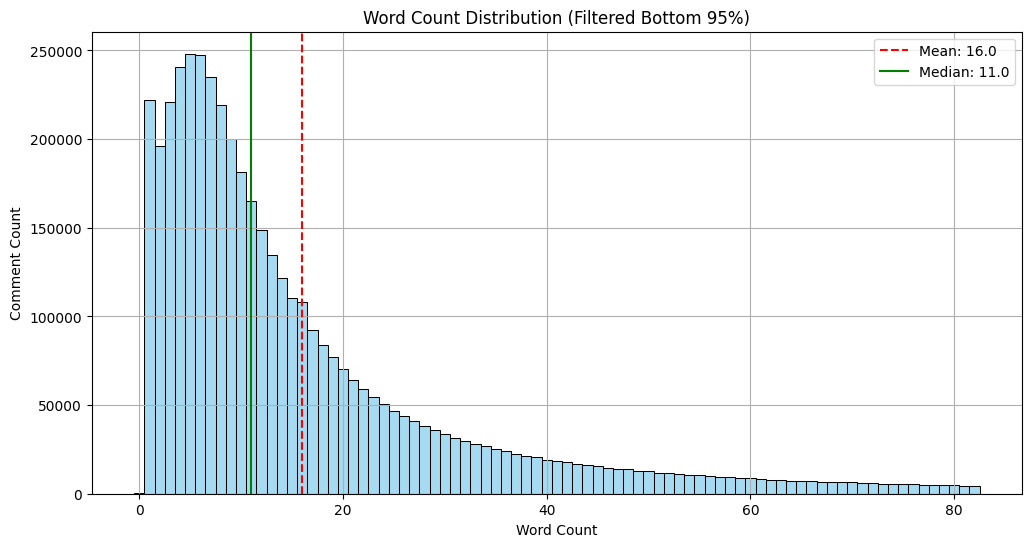

In [46]:
# Calculate 95th percentile cutoff for word_count
word_count_cutoff = df.select(pl.col("word_count")).to_pandas()["word_count"].quantile(0.95)

# Filter bottom 95% word counts
word_count_filtered_df = df.filter(pl.col("word_count") <= word_count_cutoff)

# Convert to pandas for plotting
word_count_filtered_pd = word_count_filtered_df.select(["word_count"]).to_pandas()

# Calculate mean and median
mean_wc = word_count_filtered_pd["word_count"].mean()
median_wc = word_count_filtered_pd["word_count"].median()

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(word_count_filtered_pd["word_count"], bins=100, color='skyblue', discrete=True)
plt.axvline(mean_wc, color='red', linestyle='--', label=f'Mean: {mean_wc:.1f}')
plt.axvline(median_wc, color='green', linestyle='-', label=f'Median: {median_wc:.1f}')
plt.title("Word Count Distribution (Filtered Bottom 95%)")
plt.xlabel("Word Count")
plt.ylabel("Comment Count")
plt.legend()
plt.grid(True)
plt.show()

### Distribution of emoji count for comments that have at least one emoji, filtered out top 0.5%
99.5% of the comments that use emojis have 25 emojis or less.

Note that this graph is shown in log scale, this is done to highlight values that are overshadowed by more representative counts. If we were to turn of the log scale off, the right
skewedness of the data would be more pronounced.

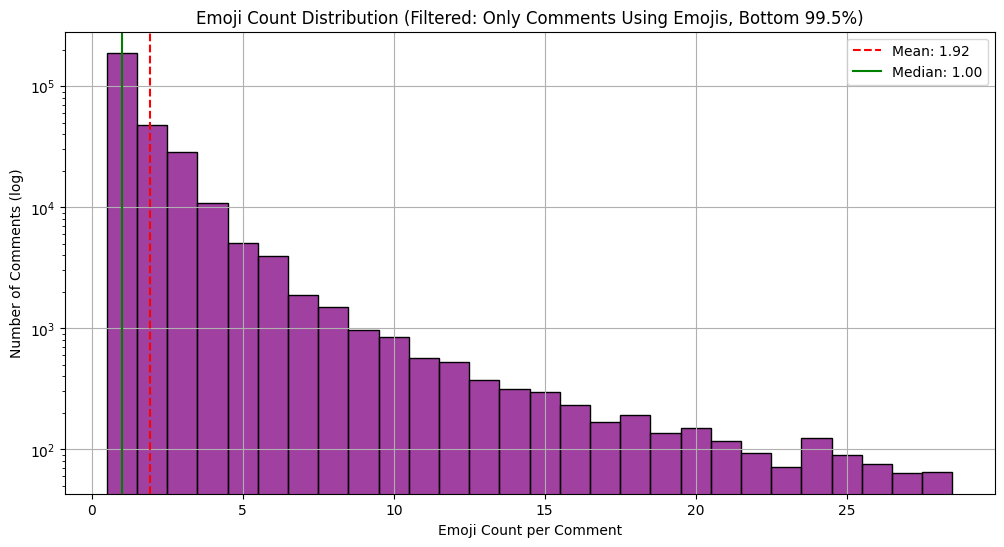

In [41]:
# Step 1 & 2: Filter with polars
emoji_only_df = df.filter(pl.col("emoji_count") > 0)

# Calculate 95th percentile cutoff for emoji_count
emoji_cutoff = emoji_only_df.select(pl.col("emoji_count")).to_pandas()["emoji_count"].quantile(0.995)

# Filter bottom 95% emoji counts
emoji_filtered_df = emoji_only_df.filter(pl.col("emoji_count") <= emoji_cutoff)

# Convert to pandas for plotting
emoji_filtered_pd = emoji_filtered_df.select(["emoji_count"]).to_pandas()


mean_emoji = emoji_filtered_pd["emoji_count"].mean()
median_emoji = emoji_filtered_pd["emoji_count"].median()

plt.figure(figsize=(12, 6))
sns.histplot(emoji_filtered_pd["emoji_count"], bins=50, color='purple', discrete=True)
plt.axvline(mean_emoji, color='red', linestyle='--', label=f'Mean: {mean_emoji:.2f}')
plt.axvline(median_emoji, color='green', linestyle='-', label=f'Median: {median_emoji:.2f}')
plt.title("Emoji Count Distribution (Filtered: Only Comments Using Emojis, Bottom 99.5%)")
plt.xlabel("Emoji Count per Comment")
plt.yscale('log')
plt.ylabel("Number of Comments (log)")
plt.legend()
plt.grid(True)
plt.show()

### Share of top level comments and replies
A little bit less than two thirds of the comments are top level comments and the remaining one third are replies.

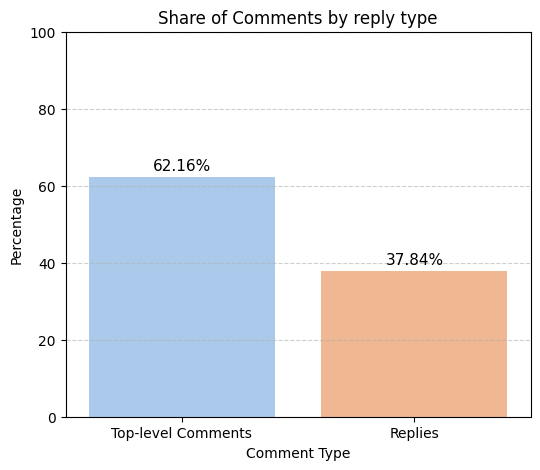

In [14]:
reply_counts = df_pd["is_reply"].value_counts(normalize=True).sort_index() * 100

# Step 2: Convert to a DataFrame
reply_df = pd.DataFrame({
    "Comment Type": ["Top-level Comments", "Replies"],
    "Percentage": reply_counts.values
})

# Step 3: Plot using hue-safe approach
plt.figure(figsize=(6, 5))
sns.barplot(data=reply_df, x="Comment Type", y="Percentage", palette="pastel", hue="Comment Type")

# Add text labels
for i, val in enumerate(reply_df["Percentage"]):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', va='bottom', fontsize=11)

plt.title("Share of Comments by reply type")
plt.ylabel("Percentage")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Distribution of comment length by reply type

**Filtered out top 5%**

Replies have a similar trend to the top level comments, showing deep skewedness to the right.

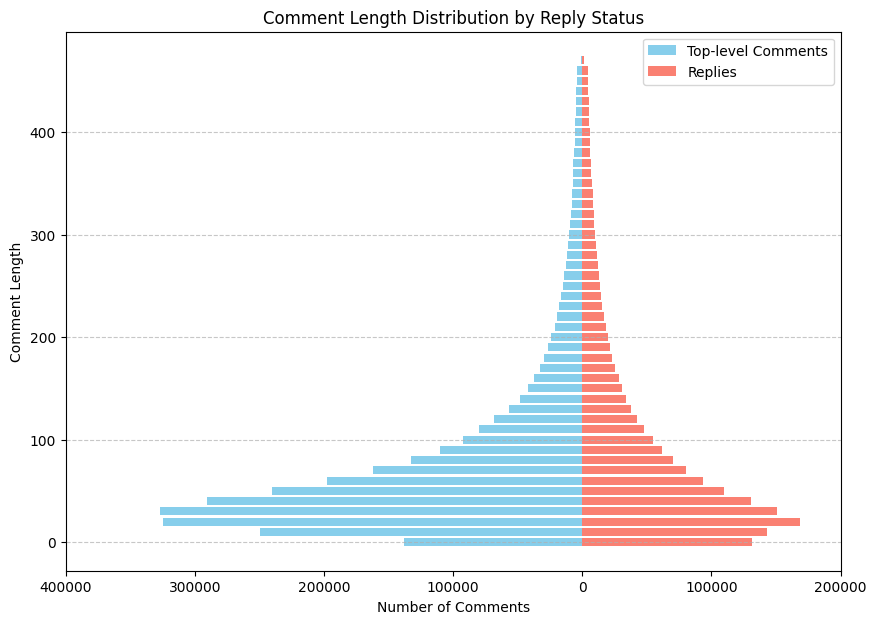

In [17]:
# Separate replies and non-replies
replies = df_filtered_pd[df_filtered_pd["is_reply"] == True]["comment_length"]
non_replies = df_filtered_pd[df_filtered_pd["is_reply"] == False]["comment_length"]

# Define bins (adjust as needed)
bins = np.arange(0, max(replies.max(), non_replies.max()) + 10, 10)

# Histogram counts
reply_counts, _ = np.histogram(replies, bins=bins)
non_reply_counts, _ = np.histogram(non_replies, bins=bins)

# Make the non-reply counts negative for left side plotting
non_reply_counts = -non_reply_counts

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.barh(bins[:-1], non_reply_counts, height=8, color='skyblue', label='Top-level Comments')
ax.barh(bins[:-1], reply_counts, height=8, color='salmon', label='Replies')

ax.set_xlabel('Number of Comments')
ax.set_ylabel('Comment Length')
ax.set_title('Comment Length Distribution by Reply Status')

# Fix the warning by setting both ticks and ticklabels
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([abs(int(x)) for x in xticks])

ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Comment length distribution, direct comparison: Replies VS Top-level Comments

**Filtered out top 5%**

Direct comparison between replies and top level comments, with their respective mean and median values.

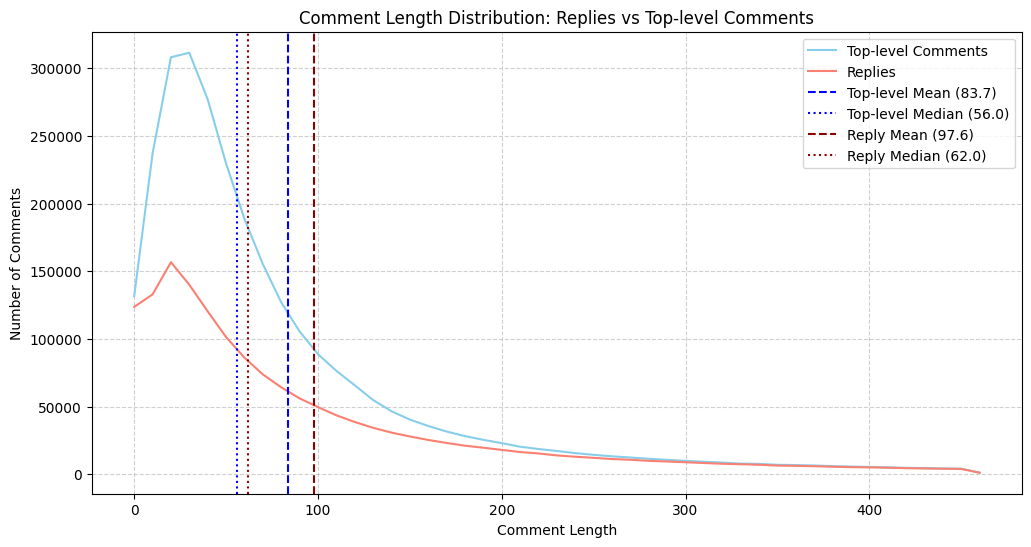

In [72]:
# Compute histograms
reply_counts, _ = np.histogram(replies, bins=bins)
non_reply_counts, _ = np.histogram(non_replies, bins=bins)

reply_mean = replies.mean()
reply_median = replies.median()

non_reply_mean = non_replies.mean()
non_reply_median = non_replies.median()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(bins[:-1], non_reply_counts, label='Top-level Comments', color='skyblue')
plt.plot(bins[:-1], reply_counts, label='Replies', color='salmon')

# Add mean and median lines
plt.axvline(non_reply_mean, color='blue', linestyle='--', linewidth=1.5, label=f'Top-level Mean ({non_reply_mean:.1f})')
plt.axvline(non_reply_median, color='blue', linestyle=':', linewidth=1.5, label=f'Top-level Median ({non_reply_median:.1f})')

plt.axvline(reply_mean, color='darkred', linestyle='--', linewidth=1.5, label=f'Reply Mean ({reply_mean:.1f})')
plt.axvline(reply_median, color='darkred', linestyle=':', linewidth=1.5, label=f'Reply Median ({reply_median:.1f})')


plt.title("Comment Length Distribution: Replies vs Top-level Comments")
plt.xlabel("Comment Length")
plt.ylabel("Number of Comments")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Normalized distribution of Replies vs Top-level Comments

**Filtered out top 5%**

The normalized distribution shows where the data is more likely to fall into. Shortly after 100 comment length, replies get a larger share than top level comments, replies do not concentrate so heavily to the left and the presence of longer replies is more common within replies, compared to top level comments, where most of the data concentrates to the left.

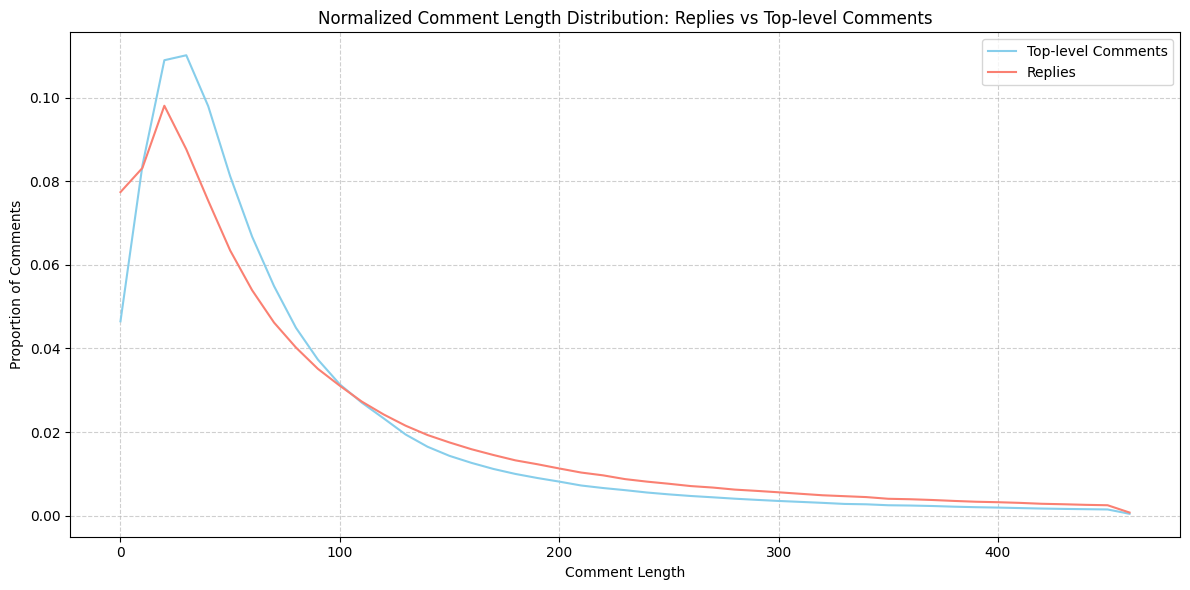

In [73]:

reply_counts, _ = np.histogram(replies, bins=bins)
non_reply_counts, _ = np.histogram(non_replies, bins=bins)

# Normalize counts to proportions
reply_props = reply_counts / reply_counts.sum()
non_reply_props = non_reply_counts / non_reply_counts.sum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(bins[:-1], non_reply_props, label='Top-level Comments', color='skyblue')
plt.plot(bins[:-1], reply_props, label='Replies', color='salmon')

plt.title("Normalized Comment Length Distribution: Replies vs Top-level Comments")
plt.xlabel("Comment Length")
plt.ylabel("Proportion of Comments")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Boxplot per comment type: Replies vs Top-level Comments

**Filtered out top 5%**

With a boxplot it is more evident to observe that the comments tend to be a little bit longer.

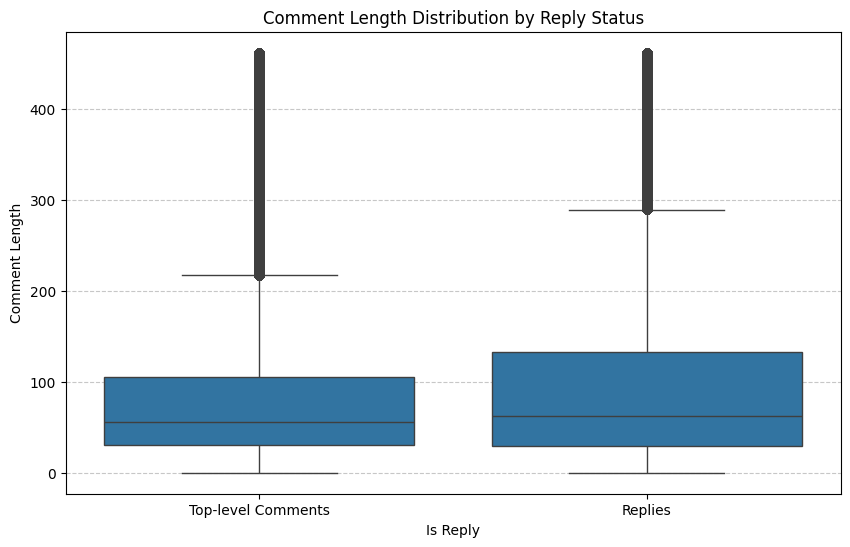

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(x="is_reply", y="comment_length", data=df_filtered_pd)

plt.xlabel("Is Reply")
plt.ylabel("Comment Length")
plt.title("Comment Length Distribution by Reply Status")
plt.xticks(ticks=[0,1], labels=["Top-level Comments", "Replies"])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Numeric values of the boxplot

**Filtered out top 5%**

The negative values are due to the interquartile calculations done for the boxplot, assuming a normal distribution. Here, due to the skewedness of our data, they hold little meaning.

In [54]:
# Group by is_reply and calculate boxplot stats
box_stats = df_filtered_pd.groupby("is_reply")["comment_length"].describe(percentiles=[0.25, 0.5, 0.75])

# Calculate IQR and whiskers
box_stats["IQR"] = box_stats["75%"] - box_stats["25%"]
box_stats["lower_whisker"] = box_stats["25%"] - 1.5 * box_stats["IQR"]
box_stats["upper_whisker"] = box_stats["75%"] + 1.5 * box_stats["IQR"]

box_stats = box_stats[["25%", "50%", "75%", "lower_whisker", "upper_whisker"]]
box_stats.columns = ["Q1", "Median", "Q3", "Lower Whisker", "Upper Whisker"]
box_stats

,Q1,Median,Q3,Lower Whisker,Upper Whisker
is_reply,,,,,
False,30.0,56.0,105.0,-82.5,217.5
True,29.0,62.0,133.0,-127.0,289.0


# Time statistics

For this second part, we will work with the publication date of the comment.

In [19]:
cols = ['video_id', 'comment_id', 'parent_id', 'comment_length', 'word_count', 'is_reply', 'emoji_count', 'published_at']
df = pd.concat([pd.read_parquet(file, columns=cols) for file in channel_paths.list_processed_files()])

## Add video_published_at

By default the data we are getting from the API doesn't have the publication date of the video, in fact, of the video we only have the video_id. So we are going to assume that the publication date of the video will be the very first comment posted for that video.

In [20]:
# Ensure published_at is datetime and timezone-free
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)

# Get the first comment date per video_id (our proxy for video publish date)
video_first_comment = df.groupby('video_id')['published_at'].min().reset_index()
video_first_comment.rename(columns={'published_at': 'video_published_at'}, inplace=True)

#  Merge it back into the original dataset
df = df.merge(video_first_comment, on='video_id', how='left')

### Comments by publication date

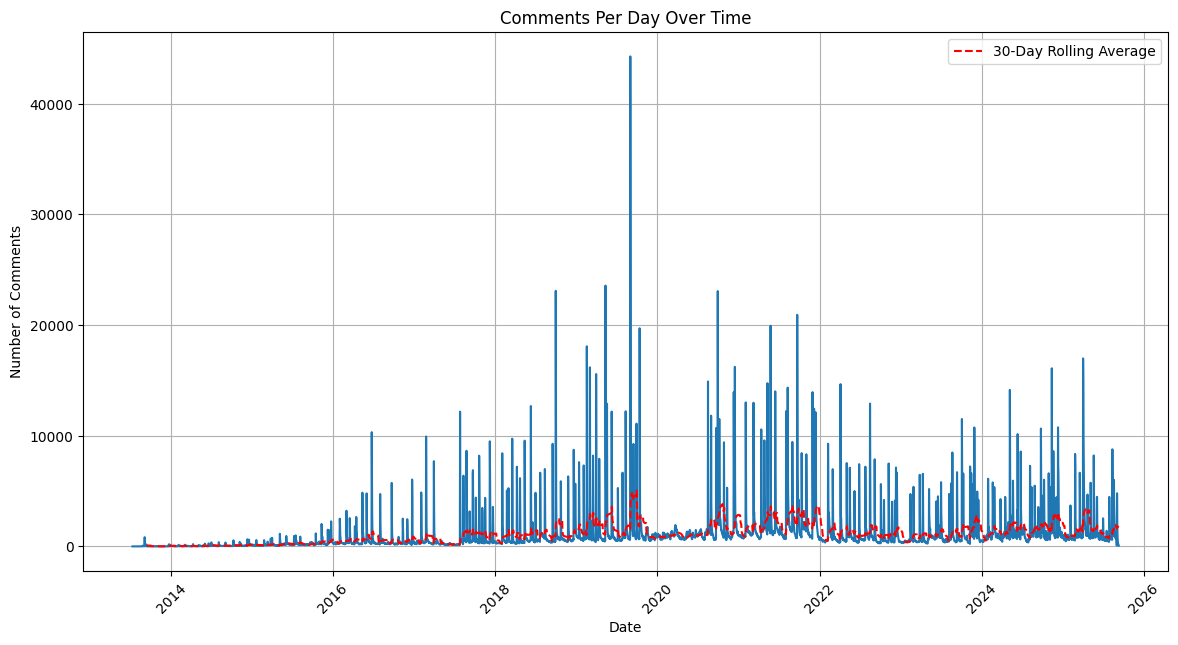

In [ ]:
# Extract date from the 'published_at' column
df['date'] = df['published_at'].dt.date

# Count comments by date
comments_by_day = df.groupby('date').size()

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(x=comments_by_day.index, y=comments_by_day.values)
plt.title("Comments Per Day Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(True)

# Count total comments per video
video_comment_counts = df.groupby('video_id').size().reset_index(name='comment_count')

## Uncomment to see the top N videos as a vertical line
# # Get top N videos
# top_n = 20
# top_videos = video_comment_counts.nlargest(top_n, 'comment_count')

# # Merge to get publish dates
# top_video_dates = top_videos.merge(video_first_comment, on='video_id')

# # Now plot vertical lines only for top videos
# for _, row in top_video_dates.iterrows():
#     plt.axvline(x=row['video_published_at'], color='red', linestyle='-.', alpha=0.5)

# Optional: add a rolling mean to smooth out fluctuations
comments_by_day_rolling = comments_by_day.rolling(window=30).mean()  # 30-day rolling window
plt.plot(comments_by_day_rolling, color='red', linestyle='--', label="30-Day Rolling Average")
plt.legend()

plt.show()

### Comments per month over time

Fun fact, that peak at mid to late 2019 corresponds to mostly comments of the video "The egg".

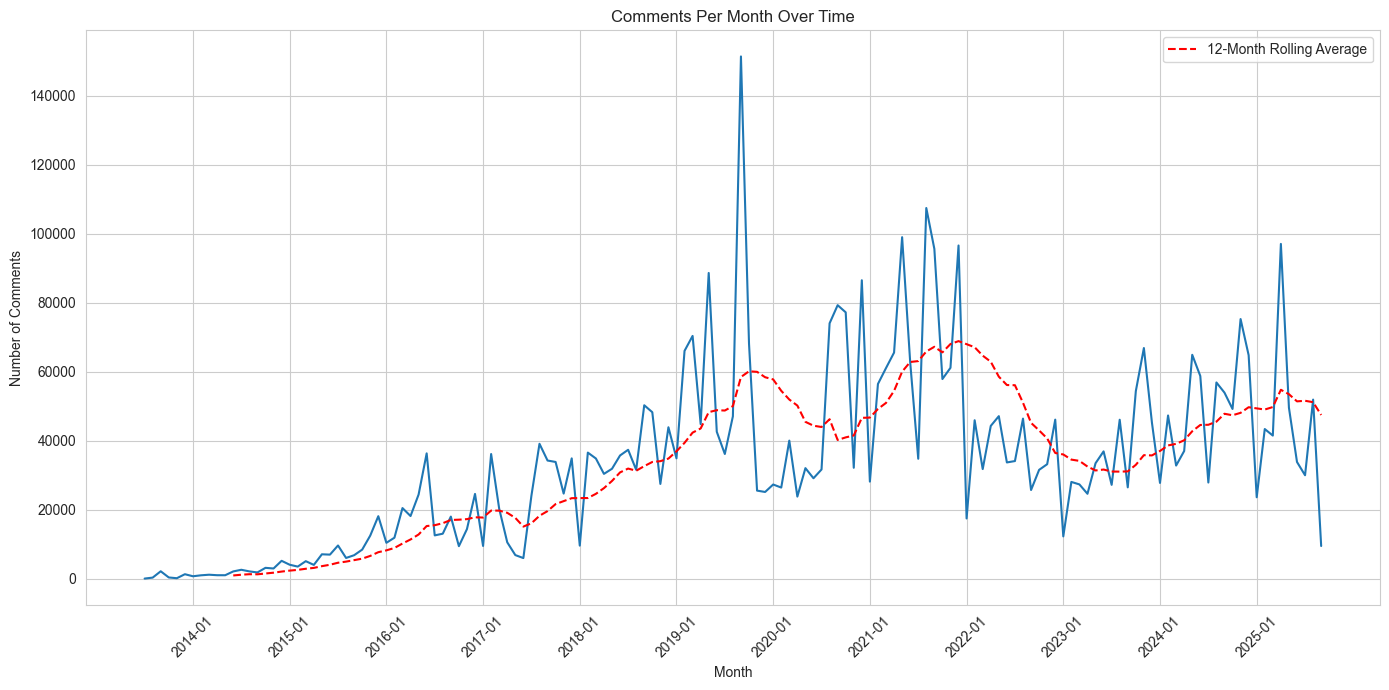

In [69]:
# Extract the month-year period (e.g., "2023-09") from 'published_at'
df['month'] = df['published_at'].dt.to_period('M')

# Convert 'month' to a string format to avoid Period errors in plotting
df['month_str'] = df['month'].dt.strftime('%Y-%m')

# Count comments by month
comments_by_month = df.groupby('month_str').size()

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(x=comments_by_month.index, y=comments_by_month.values)
plt.title("Comments Per Month Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.grid(True)

# Downsample x-axis ticks to one per year
xticks_to_show = [label for i, label in enumerate(comments_by_month.index) if '-01' in label]
plt.xticks(ticks=xticks_to_show, labels=xticks_to_show, rotation=45)

# Rolling average
comments_by_month_rolling = comments_by_month.rolling(window=12).mean()
plt.plot(comments_by_month_rolling, color='red', linestyle='--', label="12-Month Rolling Average")
plt.legend()
plt.tight_layout()
plt.show()

### Comments per Hour of Day

The hour shown is in UTC-0, all comments are saved in UTC-0 timezone by default by YouTube.

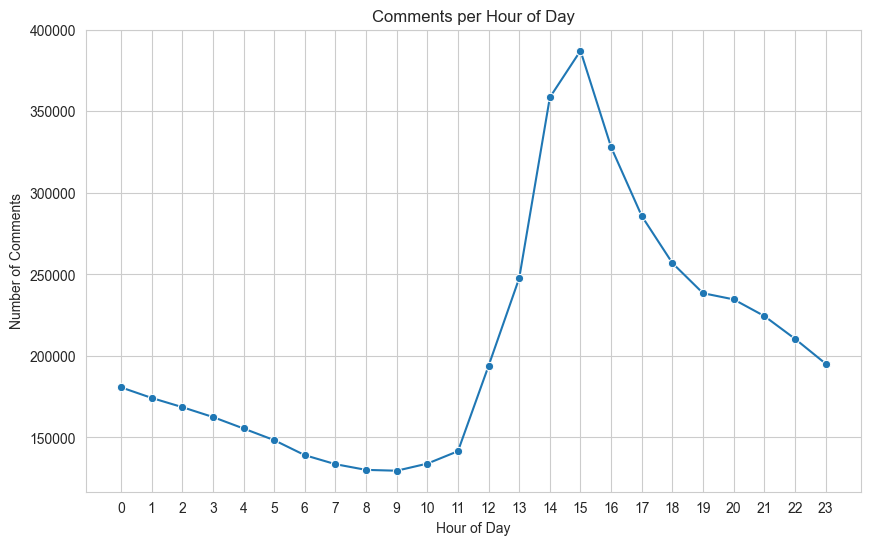

In [70]:
# Extract hour from the 'published_at' column
df['hour'] = df['published_at'].dt.hour

# Count comments by hour
comments_by_hour = df.groupby('hour').size()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=comments_by_hour.index, y=comments_by_hour.values, marker='o')
plt.title("Comments per Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Comments")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

### Comments per Day of Week

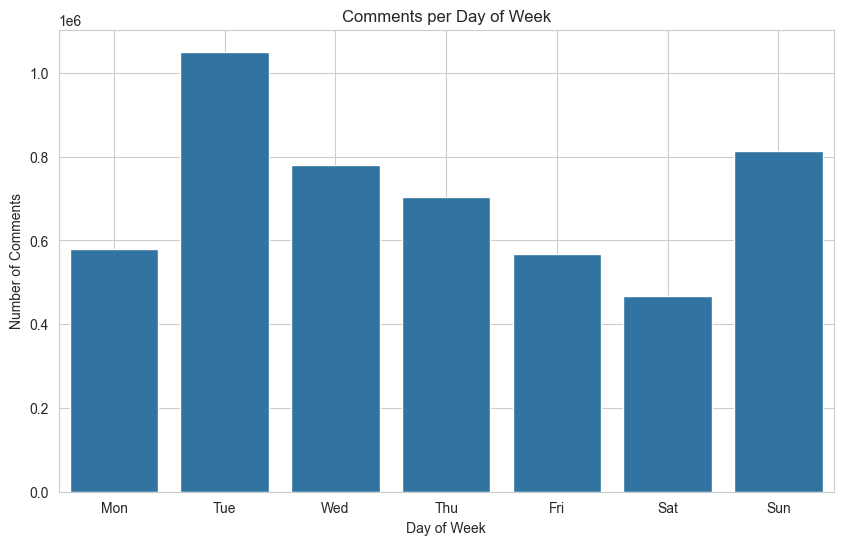

In [71]:
# Extract the day of the week from the 'published_at' column (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['published_at'].dt.dayofweek

# Count comments by day of the week
comments_by_day_of_week = df.groupby('day_of_week').size()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=comments_by_day_of_week.index, y=comments_by_day_of_week.values)
plt.title("Comments per Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Comments")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.grid(True)
plt.show()

### Normalized Comment activity distribution over day since video publication

If we were to count the days that passed since the video was published, most of the comments are made within the first days after publication.

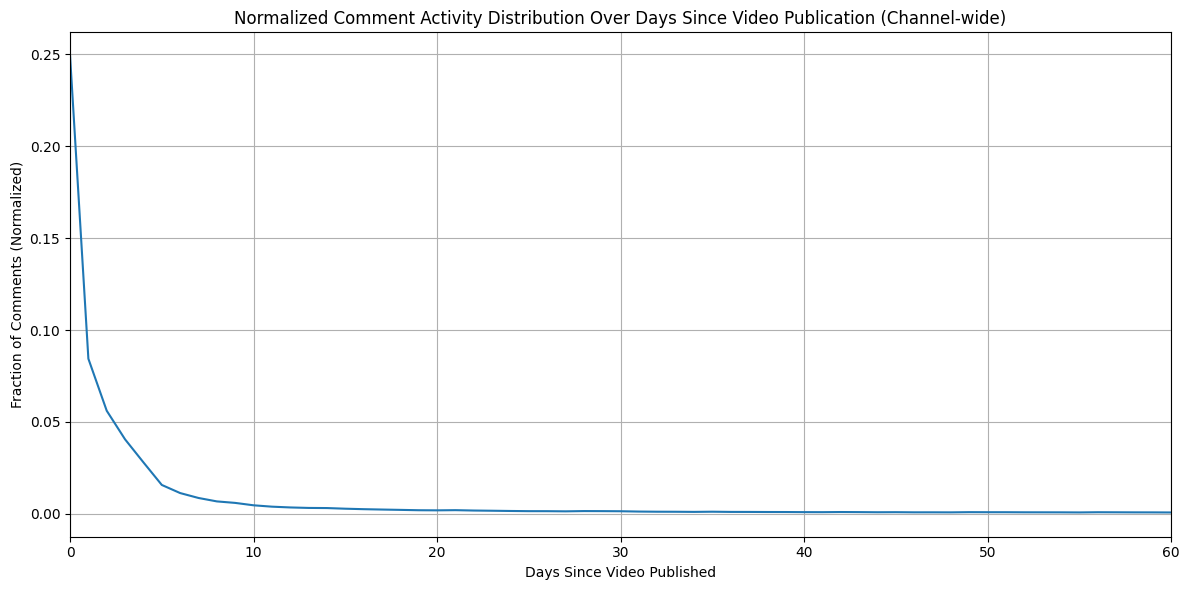

In [26]:
# Compute days since video publish for all comments
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
df['video_published_at'] = pd.to_datetime(df['video_published_at']).dt.tz_localize(None)
df['days_since_video'] = (df['published_at'] - df['video_published_at']).dt.days

# Filter out negative days, if any
df = df[df['days_since_video'] >= 0]

# Count comments per day_since_video (aggregated over all videos)
daily_counts = df.groupby('days_since_video').size().reset_index(name='comment_count')

# Normalize by total comments so the sum of normalized counts = 1
total_comments = daily_counts['comment_count'].sum()
daily_counts['normalized_count'] = daily_counts['comment_count'] / total_comments

# Plot daily normalized comment distribution
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_counts, x='days_since_video', y='normalized_count')
plt.title("Normalized Comment Activity Distribution Over Days Since Video Publication (Channel-wide)")
plt.xlabel("Days Since Video Published")
plt.ylabel("Fraction of Comments (Normalized)")
plt.xlim(0, 60)  # Optional zoom to first 60 days
plt.grid(True)
plt.tight_layout()
plt.show()

The CMF shows that approximately 50% of all comments are made within the first 10 days after a video is published.

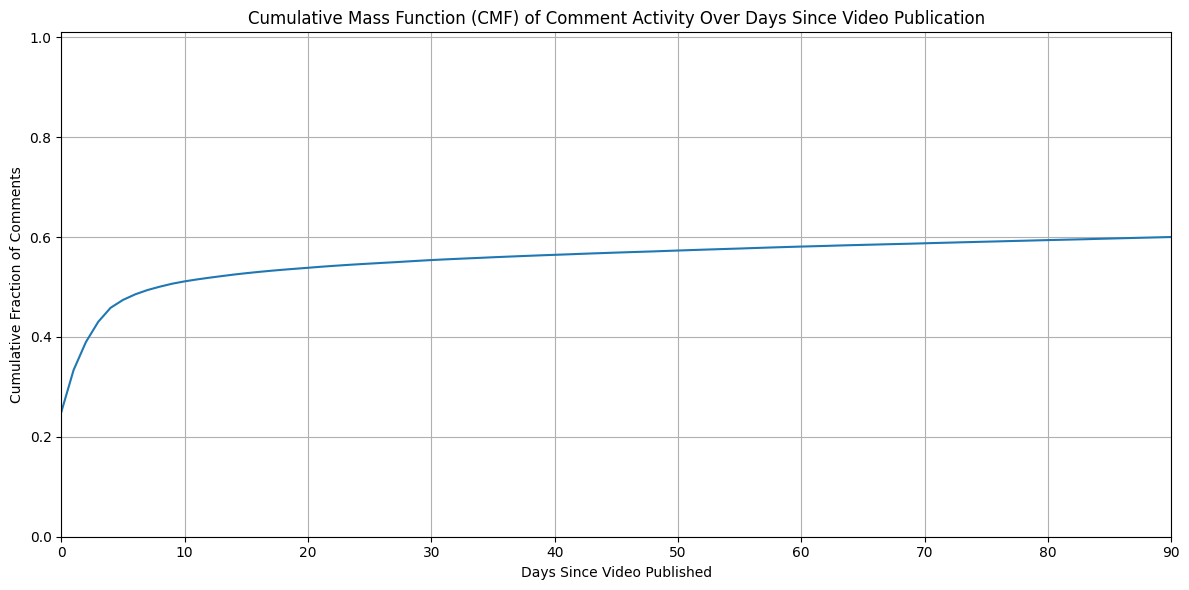

In [30]:
# Compute the Cumulative Mass Function (CMF)
daily_counts['cmf'] = daily_counts['normalized_count'].cumsum()

# Plot CMF
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_counts, x='days_since_video', y='cmf')
plt.title("Cumulative Mass Function (CMF) of Comment Activity Over Days Since Video Publication")
plt.xlabel("Days Since Video Published")
plt.ylabel("Cumulative Fraction of Comments")
plt.xlim(0, 90)  # Optional: limit to first 60 days
plt.ylim(0, 1.01)  # CMF goes from 0 to 1
plt.grid(True)
plt.tight_layout()
plt.show()

### Normalized activity over time for the Top N videos

Since we don't have information about the video, we display the id.

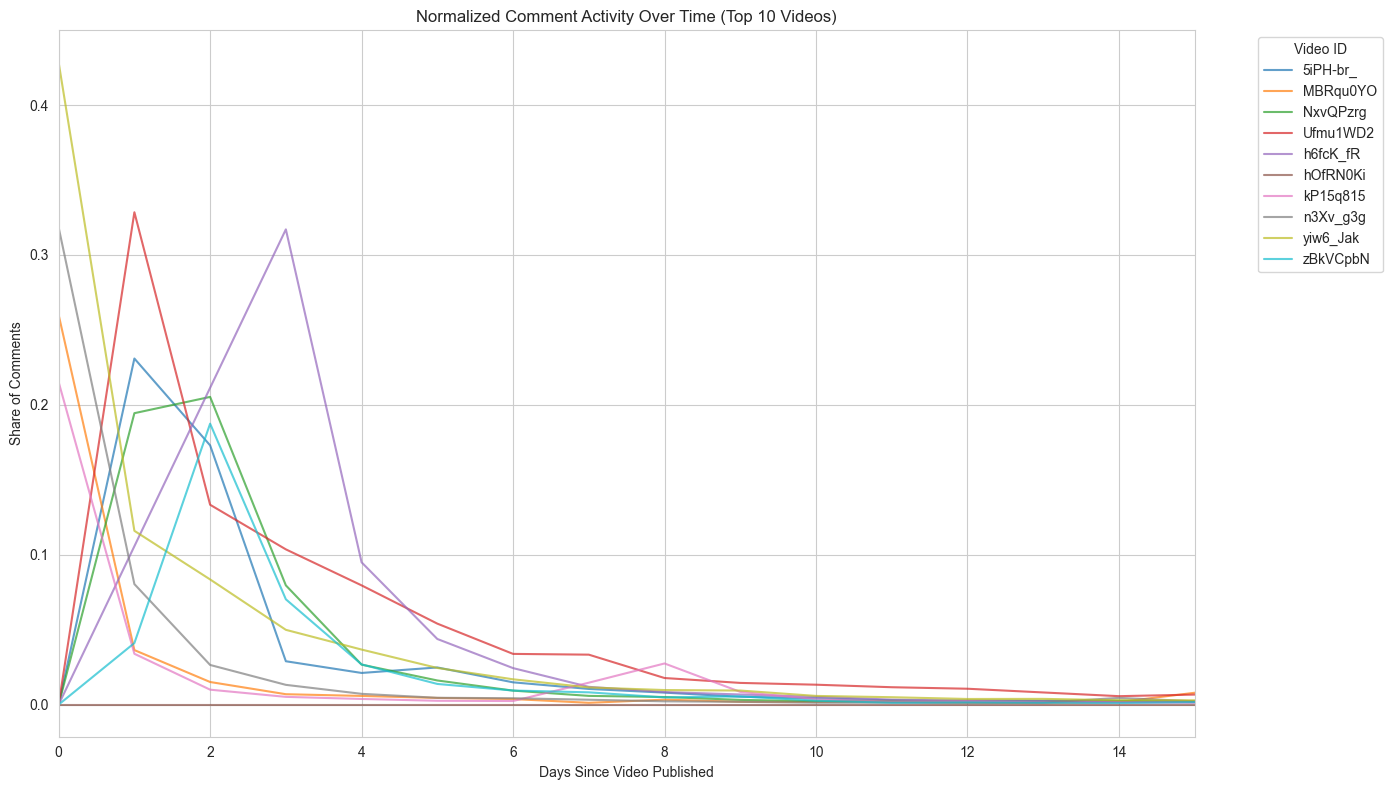

In [32]:
N = 10

# Select top N videos by total comments
top_N_videos = (
    df.groupby('video_id')
      .size()
      .nlargest(N)
      .index
)

top_df = df[df['video_id'].isin(top_N_videos)].copy()

# Compute "days since video publish" for each comment
top_df['days_since_video'] = (top_df['published_at'] - top_df['video_published_at']).dt.days

# Count comments per video per day
counts = (
    top_df.groupby(['video_id', 'days_since_video'])
          .size()
          .reset_index(name='comment_count')
)

# Normalize per video
# Total comments per video
total_comments = counts.groupby('video_id')['comment_count'].sum().rename('total')
counts = counts.merge(total_comments, on='video_id')
counts['normalized_count'] = counts['comment_count'] / counts['total']

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

for video_id, group in counts.groupby('video_id'):
    sns.lineplot(
        x=group['days_since_video'],
        y=group['normalized_count'],
        label=video_id[:8],  # Shorten video_id in legend
        alpha=0.7
    )

plt.title("Normalized Comment Activity Over Time (Top 10 Videos)")
plt.xlabel("Days Since Video Published")
plt.ylabel("Share of Comments")
plt.legend(title="Video ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 15)
plt.tight_layout()
plt.show()

### Normalized comment activity over a time period for top N videos

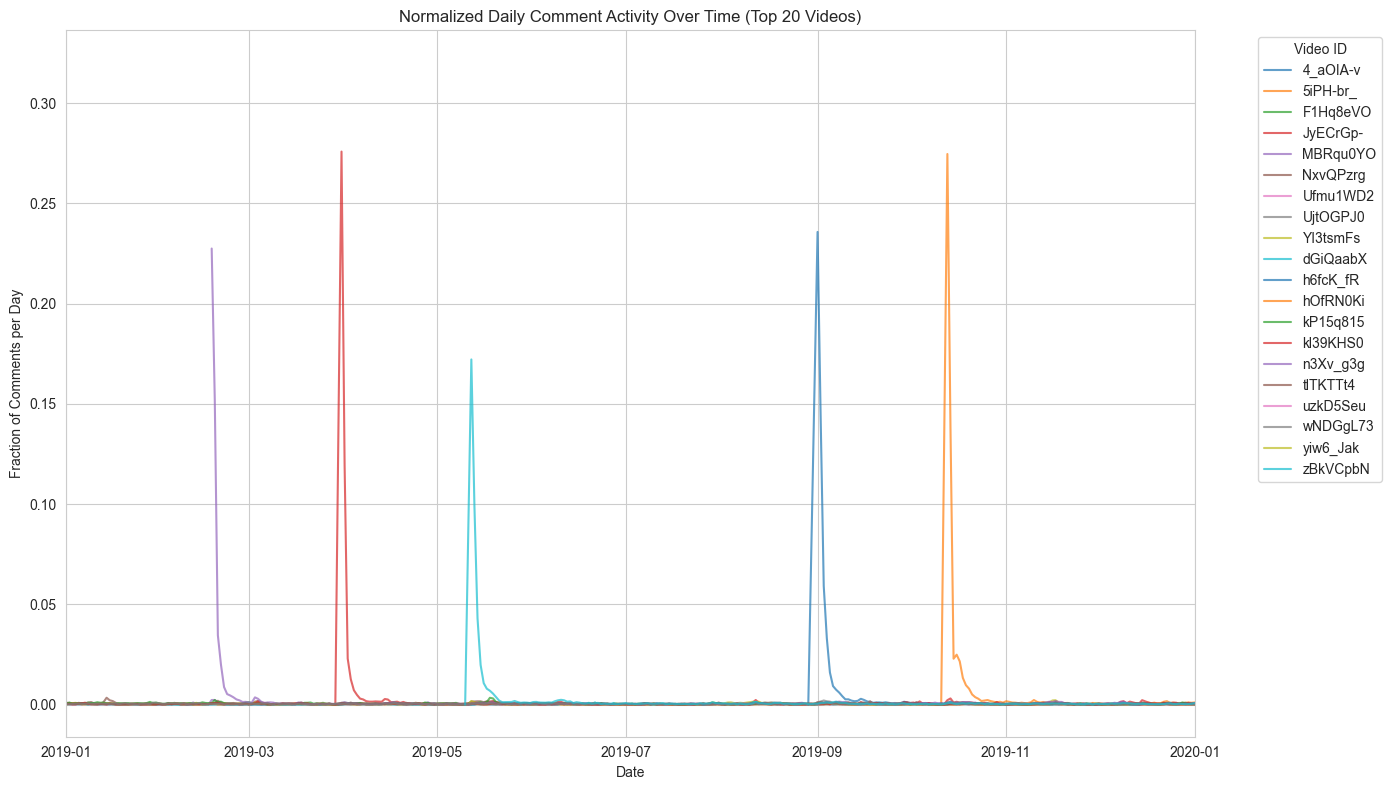

In [ ]:
N = 20

# Get top 20 videos by total comment count
top_N_videos = (
    df.groupby('video_id')
      .size()
      .nlargest(N)
      .index
)

top_df = df[df['video_id'].isin(top_N_videos)].copy()

# Group by video_id and date to get daily comment counts
top_df['date'] = top_df['published_at'].dt.date
daily_counts = (
    top_df.groupby(['video_id', 'date'])
          .size()
          .reset_index(name='comment_count')
)

# Normalize comment counts per video
# Get total comments per video
total_comments = daily_counts.groupby('video_id')['comment_count'].sum().rename('total')
daily_counts = daily_counts.merge(total_comments, on='video_id')
daily_counts['normalized_count'] = daily_counts['comment_count'] / daily_counts['total']

# Convert 'date' back to datetime for plotting
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

for video_id, group in daily_counts.groupby('video_id'):
    sns.lineplot(
        x=group['date'],
        y=group['normalized_count'],
        label=video_id[:8],  # Shorten video ID for readability
        alpha=0.7
    )

plt.xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01"))
plt.title(f"Normalized Daily Comment Activity Over Time (Top {N} Videos)")
plt.xlabel("Date")
plt.ylabel("Fraction of Comments per Day")
plt.legend(title="Video ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Comment Volumne vs. Video Publish Date

Each dot is a video

The increase of video publication in the later dates, 2024-2026 is the introduction of **shorts** format to the channel. Currently there is no way of identifying clearly a regular video vs a short via the API (this may change).

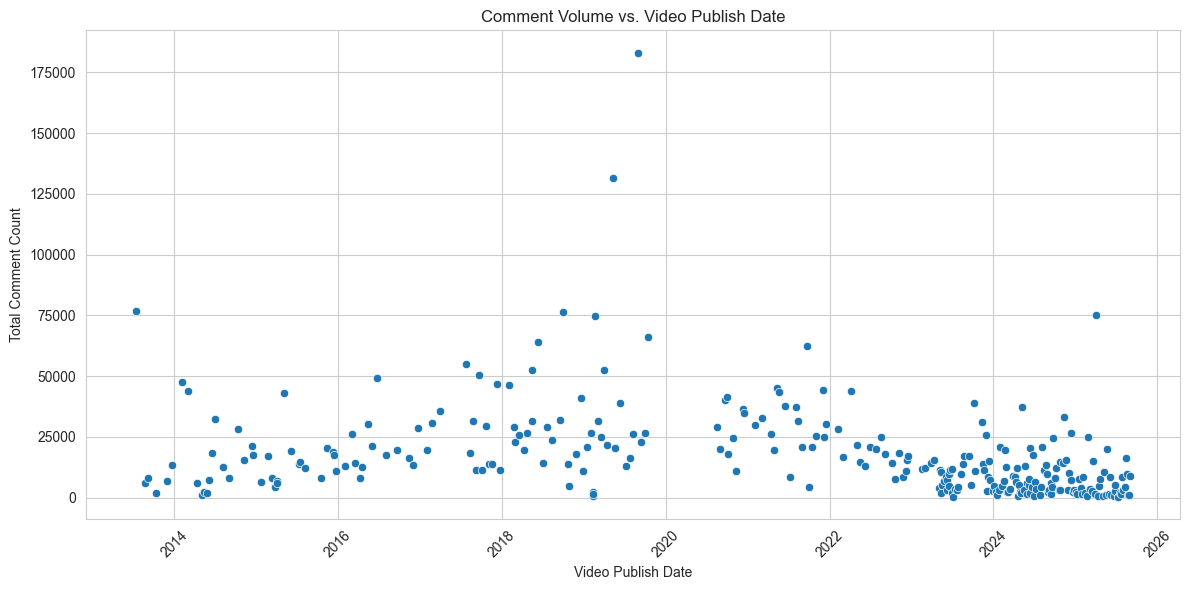

In [ ]:
# Total comments per video + video publish date
video_comment_volume = (
    df.groupby('video_id')
      .agg(comment_count=('comment_id', 'count'), video_published_at=('video_published_at', 'first'))
      .sort_values('video_published_at')
)

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=video_comment_volume, x='video_published_at', y='comment_count')
plt.title("Comment Volume vs. Video Publish Date")
plt.xlabel("Video Publish Date")
plt.ylabel("Total Comment Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Average comment length over time: Replies vs Top-level Comments

People has gotten less chatty over time.

We have to be careful thoug: **we cannot just simply say that comments in average are shorter**.
The graph displays such but that could be due to:
- Lack of sampling of the data over time, later years have more samples, so earlier are more volatile to outliers
- Shift of video content, for example, to accomodate a larger audience.

etc.

Drawing statistical meaning from data usually requires more robust statistical methods that are outside the scope of this project.

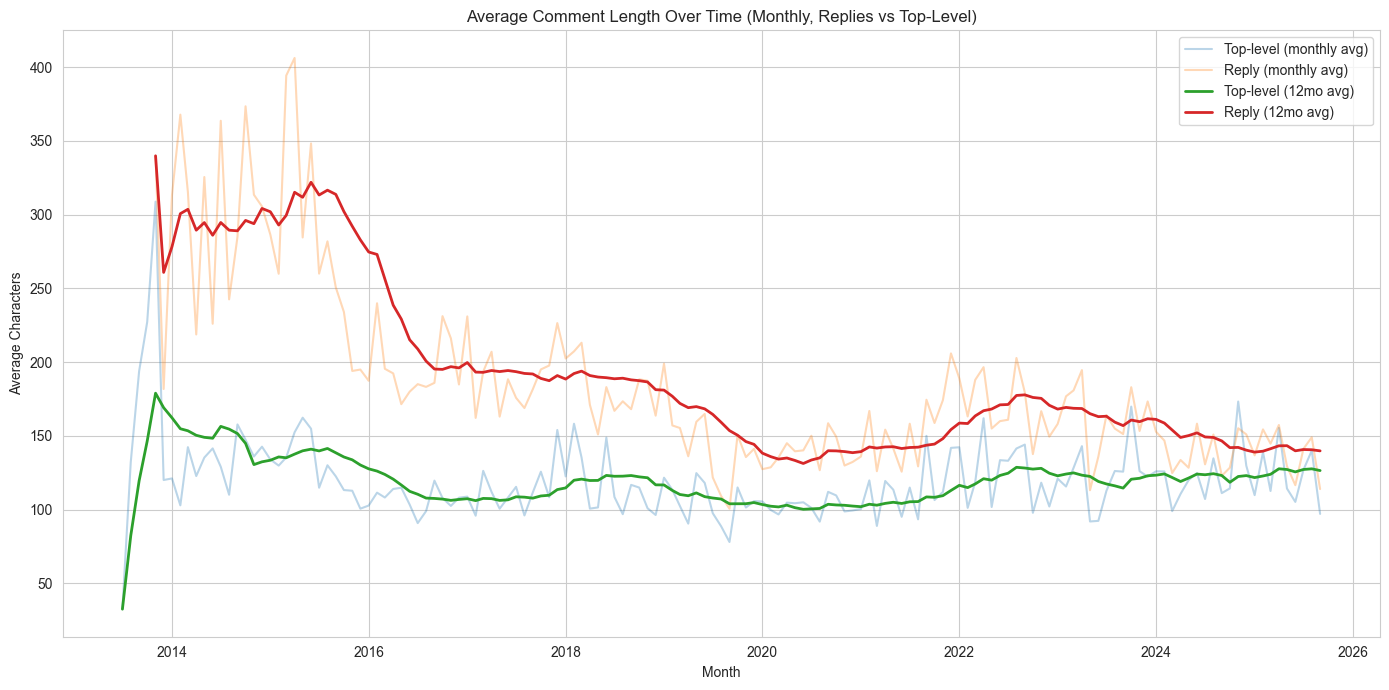

In [ ]:
# Step 1: Create month column (start of the month)
df['month'] = df['published_at'].dt.to_period('M').dt.to_timestamp()

# Step 2: Group by month and reply status
monthly_length = df.groupby(['month', 'is_reply'])['comment_length'].mean().unstack()

# Step 3: Sort and apply 12-month rolling average
monthly_length = monthly_length.sort_index()
rolling_avg = monthly_length.rolling(window=12, min_periods=1).mean()

# Step 4: Plot
plt.figure(figsize=(14, 7))

# Raw monthly means
sns.lineplot(x=monthly_length.index, y=monthly_length[False], label='Top-level (monthly avg)', alpha=0.3)
sns.lineplot(x=monthly_length.index, y=monthly_length[True], label='Reply (monthly avg)', alpha=0.3)

# 12-month rolling averages
sns.lineplot(x=rolling_avg.index, y=rolling_avg[False], label='Top-level (12mo avg)', linewidth=2)
sns.lineplot(x=rolling_avg.index, y=rolling_avg[True], label='Reply (12mo avg)', linewidth=2)

# Labels & formatting
plt.title("Average Comment Length Over Time (Monthly, Replies vs Top-Level)")
plt.xlabel("Month")
plt.ylabel("Average Characters")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
